## How to use this script

This script validates an algorithmic framework similar to that of `curvatubes` (PyTorch + external optimizer),\
but in the special case of the L^2 Willmore flow. It contains the following experiments:

- **Exp 1a** - Sphere (not very interesting)
- **Exp 1b** - Clifford torus
- **Exp 1c** - Lawson surface of genus 2

For more details, please refer to my paper [here](https://arxiv.org/abs/2103.04856)!

**If you find any problem in this script**, please contact me at a.song19@imperial.ac.uk.

In [1]:
!pip install nibabel

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [198]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import string
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
dtype = torch.cuda.FloatTensor

# curvatubes imports
from cvtub.utils import slices, single, load_nii, save_nii, random_init, init_balls
from cvtub.energy import discrepancy, ratio_discr

import cvtub
from cvtub.curvdiags import kap_eps, curvhist, density_scatter

def plot_curvature_diagram(u, save = True, save_name = 'curvature_diagram.png'):

    kap1_eps, kap2_eps = kap_eps(u)

    kap1_vals, kap2_vals, areas, genus = \
    curvhist(u, kap1_eps, kap2_eps, delta_x = 0.01, show_figs = False)
    gr = 100
    x,y = np.clip(kap1_vals, -gr,gr), np.clip(kap2_vals, -gr, gr)
    density_scatter(x,y, areas, showid = True, equalaxis = True, 
                    bins = gr, xlabel = 'kap1', 
                    ylabel = 'kap2', save = save, save_name = save_name)
    return kap1_vals, kap2_vals



def get_mean_curvatures(u):
    kap1_eps, kap2_eps = kap_eps(u)
    kap1_vals, kap2_vals, areas, genus = \
    curvhist(u, kap1_eps, kap2_eps, delta_x = 0.01, show_figs = False)
    h = areas*(kap1_vals + kap2_vals)
    return h/sum(areas), genus



def print_quality(u):
    try:
        u = u.detach().cpu().numpy()
    except:
        pass
    h, genus = get_mean_curvatures(u)

    h1 = np.abs(h)
    #hh = h[h<np.quantile(h, .8)]
    print("genus abs(h).mean, q.1, q.9", genus, h1.mean(), np.quantile(h, .1), np.quantile(h, .9))



# Experiment 1 - Validation with Willmore minimizers

In [ ]:
# Create some folders to save the results

snapshot_folder = '../results/Experiment_1/'

if not os.path.exists(snapshot_folder):
    print(snapshot_folder + ' folder does not exist, creating it...')
    os.makedirs(snapshot_folder)
if not os.path.exists(snapshot_folder + 'Curves/'):
    print('Curves subfolder does not exist, creating it...')
    os.makedirs(snapshot_folder + 'Curves/')


In [199]:
# Main function that makes the Willmore flow

from cvtub.generator import _generate_shape

def Willmore_flow(v0, maxeval = 1000, eps=.05, delta_x=.01, display_all = True, callback=print_quality) :  
    '''
        L2 flow of the Willmore phase-field
    
            Feps(u) = integral of (1/eps) { ( eps Lap(u) - W'(u) / eps )^2  } dx^3
            
        which is a diffuse approximation of the Willmore energy
            
            F(S)    = integral on S of { H^2 } dA
            
            where H = kap_1 + kap_2 is the mean curvature
    
    '''
    
    a20, a11, a02, b10, b01, c = 1,2,1,0,0,0 # polynomial coeffs corresponding to (kap_1 + kap_2)^2
    params = eps, a20, a11, a02, b10, b01, c
    xi =  1e-6
    flow_type = 'L2'
    mode = 'replicate'
    optim_method = 'bfgs'
    sigma_blur = 1
    Z,X,Y = v0.shape

    # BFGS internal parameters
    optim_props = {'maxeval': maxeval, 'sigma_blur': sigma_blur, 'lr': 1, #.01, # lr = learning_rate
                   'bfgs_max_iter' : 20, 'history_size' : 10, 'line_search_fn' : 'strong_wolfe',
                   'display_it_nb' : 500, 'fill_curve_nb' : 50} # display / fill curve every ... its
    
    
    if False:
        optim_method = 'adam'
        optim_props = {'maxeval': maxeval, 'sigma_blur': sigma_blur, 'lr': .05, 'eps_adam' : 1e-2, 
                       'betas' : (0.9,0.999), 'weight_decay' : 0, 'amsgrad' : False,
                       'display_it_nb' : 1000, 'fill_curve_nb' : 50}
        optim_props["eps_adam"] = eps
        

        
    u, E = _generate_shape(v0, params, delta_x, xi, optim_method, optim_props, flow_type, mode,
                           snapshot_folder = snapshot_folder, display_all = display_all,
                           return_energy = True, callback=print_quality)
    
    torch.cuda.empty_cache()

    return u.detach().cpu().numpy(), E

def compare_relative(val, target_val) :
    print('value = {}'.format(val))
    print('target value = {}'.format(target_val))
    print('{} % of relative error'.format(100 * np.abs(val - target_val) / target_val))


### A note on the size of the simulation domain in replicate mode:

When initializing the phase-field u with values close to +1 or -1, make sure that there is enough -1 values
between the shape and the boundary of the simulation domain. Otherwise, after touching the boundary during the
flow, the shape tends to become perpendicular to it because of the replicate conditions.

That is why the simulations below are run on a domain much larger than the central region where
interesting things happen. However, the bigger the shape is, the better the approximation
of the original sharp-interface problem is (but then computation time also becomes longer).

##force_field -


In [5]:
%load_ext autoreload
%autoreload 2

-12809.73681855425 21155.91884713714 16.578126937128324


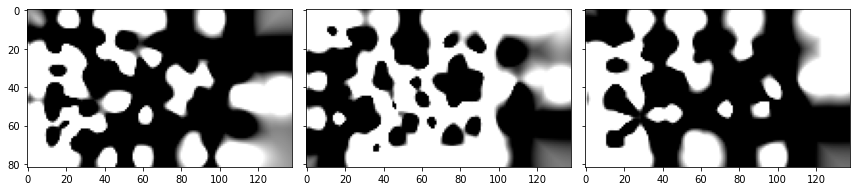

In [266]:

import scipy.stats
import numpy as np
input = np.load("../../../OUTPUT/box_test/mirror_add__2914/2914_500_force_field.npy")

print(input.min(), input.max(), np.abs(input).mean())
input = np.clip(0.5*input, -1,1)
input2 = input
input2 = np.pad(input, ((0,0),(0,0),(1,0)), 'constant')
#input2 = input2.T
input2[:, :, 0] = input[:, :, 1]
v0 = torch.Tensor(input2)
slices(v0)

polykap_deg2 bfgs L2 replicate
eps 0.05 coeffs [1, 2, 1, 0, 0, 0]
dx = 0.050, LZ = 3.00, LX = 4.100, LY = 6.900, xi = 1e-06
{'maxeval': 4000, 'sigma_blur': 1, 'lr': 1, 'bfgs_max_iter': 20, 'history_size': 10, 'line_search_fn': 'strong_wolfe', 'display_it_nb': 500, 'fill_curve_nb': 50}

 umin = -1.0000141859054565, umax = 1.0005919933319092
 m =  0.038 

E = 6242.419921875
at BFGS iteration 1 and eval 25,   umin = -1.005589485168457, umax = 1.0102347135543823


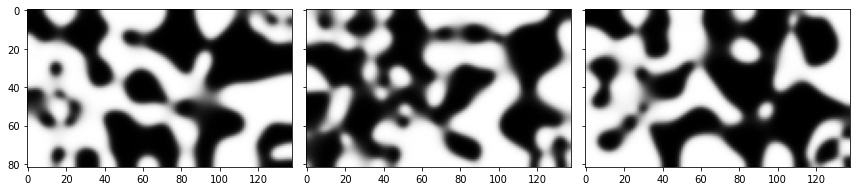

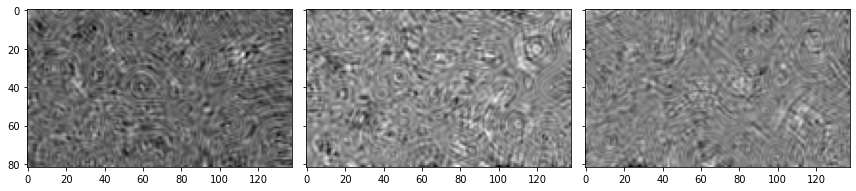


  100: E = 1.17e+02, genus abs(h).mean, quatile .1 , .9 1109.5 2.638112574382521e-05 -2.6421904958044194e-05 2.1533974519304156e-05

  200: E = 1.06e+02, genus abs(h).mean, quatile .1 , .9 1110.5 2.633165638546242e-05 -2.619592172160762e-05 2.152629941405312e-05

  300: E = 1.03e+02, genus abs(h).mean, quatile .1 , .9 1110.5 2.62874303584446e-05 -2.613056448574828e-05 2.1432851728590415e-05

  400: E = 1.02e+02, genus abs(h).mean, quatile .1 , .9 1113.5 2.619681041142098e-05 -2.612961179423508e-05 2.1263565000936705e-05

  500: E = 1.00e+02, genus abs(h).mean, quatile .1 , .9 1114.5 2.6115757611287568e-05 -2.6013218192867514e-05 2.1090544449854815e-05

 
 at eval 500
grad_L1mean = 2.5395e-04
latex_grad_max = 2.2834e-02
m =   0.039 

E = 100.32071685791016
at BFGS iteration 24 and eval 515,   umin = -1.0005383491516113, umax = 1.0006252527236938


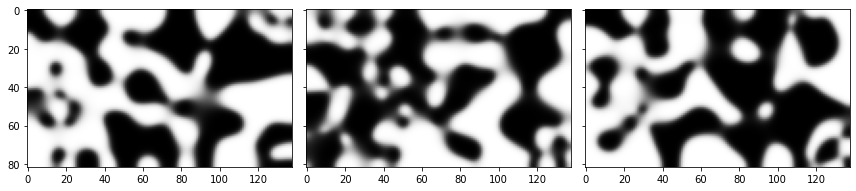

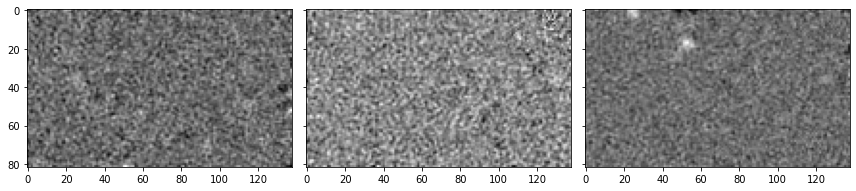


  600: E = 9.93e+01, genus abs(h).mean, quatile .1 , .9 1114.0 2.603866485159657e-05 -2.5800189195743792e-05 2.0999355703058435e-05

  700: E = 9.84e+01, genus abs(h).mean, quatile .1 , .9 1115.5 2.597652570836064e-05 -2.577719559870478e-05 2.091221617444393e-05

  800: E = 9.76e+01, genus abs(h).mean, quatile .1 , .9 1114.0 2.5901872665101082e-05 -2.5664617007410096e-05 2.0845111656115636e-05

  900: E = 9.67e+01, genus abs(h).mean, quatile .1 , .9 1114.5 2.5825749380365823e-05 -2.5411914445172854e-05 2.076755309870767e-05

 1000: E = 9.60e+01, genus abs(h).mean, quatile .1 , .9 1116.0 2.5733837617669746e-05 -2.534596736796165e-05 2.0606365915211324e-05

 
 at eval 1000
grad_L1mean = 1.3175e-04
latex_grad_max = 8.5357e-03
m =   0.039 

E = 95.96106719970703
at BFGS iteration 47 and eval 1006,   umin = -1.0012080669403076, umax = 1.0008647441864014


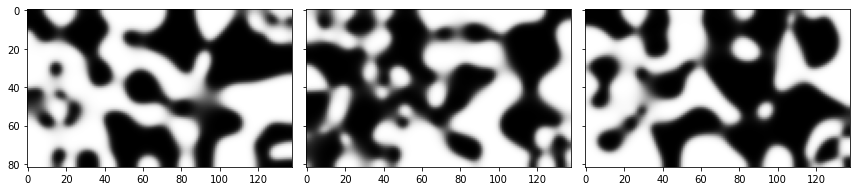

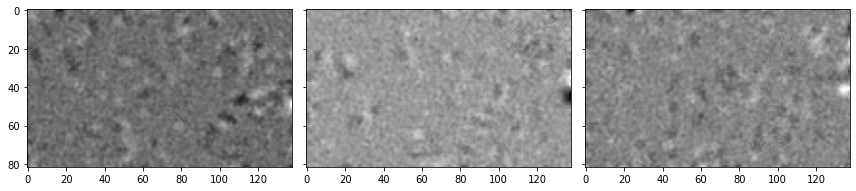


 1100: E = 9.52e+01, genus abs(h).mean, quatile .1 , .9 1118.5 2.5650806124586568e-05 -2.5197439180049833e-05 2.0571464923109363e-05

 1200: E = 9.43e+01, genus abs(h).mean, quatile .1 , .9 1115.0 2.5610679679148487e-05 -2.5062621562785923e-05 2.052733879128131e-05

 1300: E = 9.35e+01, genus abs(h).mean, quatile .1 , .9 1113.75 2.5517072836462766e-05 -2.4989094802648985e-05 2.052093352737117e-05

 1400: E = 9.26e+01, genus abs(h).mean, quatile .1 , .9 1111.75 2.5424416221068813e-05 -2.489741447154411e-05 2.0306301372424756e-05

 1500: E = 9.18e+01, genus abs(h).mean, quatile .1 , .9 1112.75 2.5335553860307092e-05 -2.4942674447154452e-05 2.023869308447505e-05

 
 at eval 1500
grad_L1mean = 1.1671e-04
latex_grad_max = 9.6087e-03
m =   0.039 

E = 91.80355834960938
at BFGS iteration 70 and eval 1503,   umin = -1.0012575387954712, umax = 1.0008976459503174


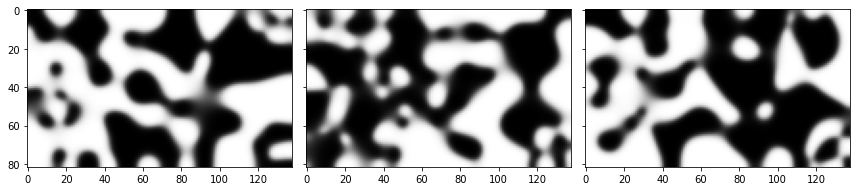

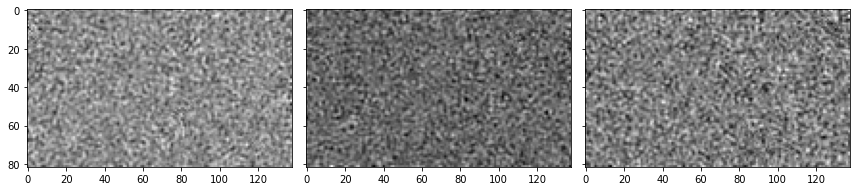


 1600: E = 9.10e+01, genus abs(h).mean, quatile .1 , .9 1114.75 2.5277608229470385e-05 -2.4793243732493482e-05 2.019824809725075e-05

 1700: E = 9.01e+01, genus abs(h).mean, quatile .1 , .9 1112.75 2.5193102569474728e-05 -2.45920215675394e-05 2.0115139520034143e-05

 1800: E = 8.92e+01, genus abs(h).mean, quatile .1 , .9 1110.75 2.5109372408874022e-05 -2.463109240189109e-05 2.003923127760881e-05

 1900: E = 8.69e+01, genus abs(h).mean, quatile .1 , .9 1112.25 2.4999265410294236e-05 -2.4514258623888943e-05 1.995721123710594e-05

 2000: E = 8.47e+01, genus abs(h).mean, quatile .1 , .9 1110.25 2.489533676336077e-05 -2.434410097082477e-05 1.9909722418550852e-05

 
 at eval 2000
grad_L1mean = 2.0681e-04
latex_grad_max = 2.9786e-02
m =   0.039 

E = 84.7013931274414
at BFGS iteration 94 and eval 2017,   umin = -1.0007433891296387, umax = 1.001338005065918


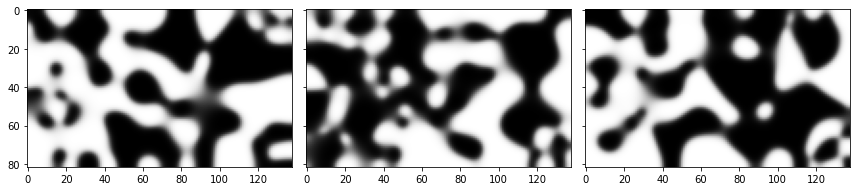

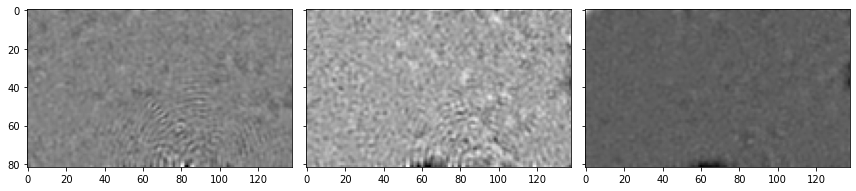


 2100: E = 8.34e+01, genus abs(h).mean, quatile .1 , .9 1109.25 2.4873151736959966e-05 -2.427692276859116e-05 1.986889262660494e-05

 2200: E = 8.24e+01, genus abs(h).mean, quatile .1 , .9 1110.25 2.4830848190091806e-05 -2.4277738925093986e-05 1.9861273480578426e-05

 2300: E = 8.16e+01, genus abs(h).mean, quatile .1 , .9 1108.25 2.4802656856548063e-05 -2.4165196894878202e-05 1.987517984742542e-05

 2400: E = 8.09e+01, genus abs(h).mean, quatile .1 , .9 1109.25 2.4776888114486214e-05 -2.409106572169465e-05 1.9846259903076518e-05

 2500: E = 8.03e+01, genus abs(h).mean, quatile .1 , .9 1109.25 2.473952116868849e-05 -2.395546069081149e-05 1.9824590443775834e-05

 
 at eval 2500
grad_L1mean = 1.2701e-04
latex_grad_max = 4.3429e-03
m =   0.039 

E = 80.25216674804688
at BFGS iteration 117 and eval 2513,   umin = -1.0005483627319336, umax = 1.0005278587341309


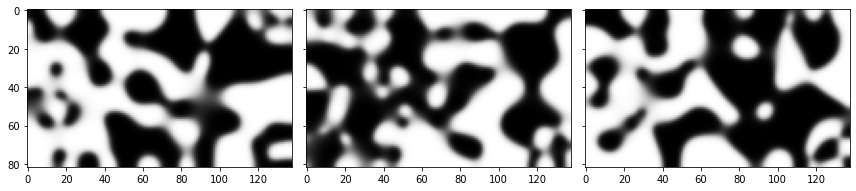

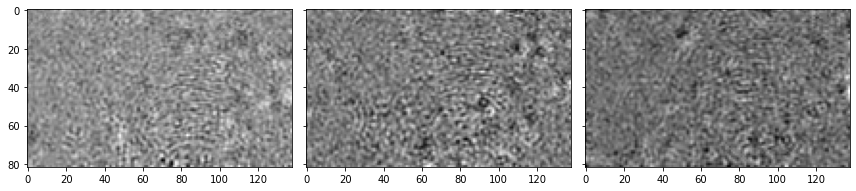


 2600: E = 7.95e+01, genus abs(h).mean, quatile .1 , .9 1110.25 2.4712914491380777e-05 -2.3928829523506575e-05 1.97669639917125e-05

 2700: E = 7.89e+01, genus abs(h).mean, quatile .1 , .9 1108.25 2.469665722958181e-05 -2.3940775729762236e-05 1.9696956556115857e-05

 2800: E = 7.82e+01, genus abs(h).mean, quatile .1 , .9 1107.75 2.464749321640581e-05 -2.3804908768005483e-05 1.964331846483729e-05

 2900: E = 7.76e+01, genus abs(h).mean, quatile .1 , .9 1107.25 2.4618483840294043e-05 -2.384932426561568e-05 1.9507569986351298e-05

 3000: E = 7.69e+01, genus abs(h).mean, quatile .1 , .9 1107.25 2.4579315469136287e-05 -2.384513665751381e-05 1.9451699598407425e-05

 
 at eval 3000
grad_L1mean = 1.0243e-04
latex_grad_max = 6.5498e-03
m =   0.040 

E = 76.9383773803711
at BFGS iteration 140 and eval 3007,   umin = -1.0004143714904785, umax = 1.0011041164398193


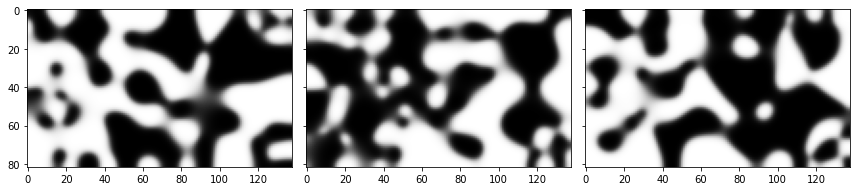

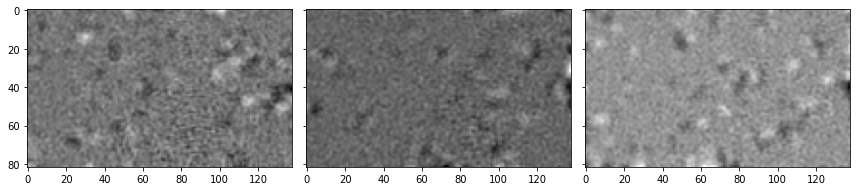


 3100: E = 7.63e+01, genus abs(h).mean, quatile .1 , .9 1105.75 2.4513526629730842e-05 -2.364690717199126e-05 1.9362132896309034e-05

 3200: E = 7.57e+01, genus abs(h).mean, quatile .1 , .9 1106.25 2.4459634932393894e-05 -2.3466817128214974e-05 1.9258648884167722e-05

 3300: E = 7.52e+01, genus abs(h).mean, quatile .1 , .9 1104.75 2.4419092648942247e-05 -2.34090074884762e-05 1.9095311812150128e-05

 3400: E = 7.46e+01, genus abs(h).mean, quatile .1 , .9 1102.25 2.436103405356798e-05 -2.3170358324565064e-05 1.915621987288274e-05

 3500: E = 7.39e+01, genus abs(h).mean, quatile .1 , .9 1101.75 2.4309983529093418e-05 -2.3086892221677405e-05 1.9036694634348145e-05

 
 at eval 3500
grad_L1mean = 1.1978e-04
latex_grad_max = 7.2829e-03
m =   0.041 

E = 73.92684173583984
at BFGS iteration 164 and eval 3520,   umin = -1.0008264780044556, umax = 1.0023465156555176


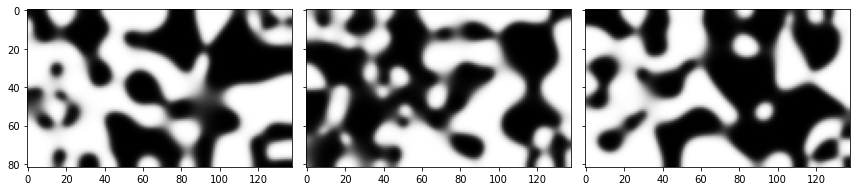

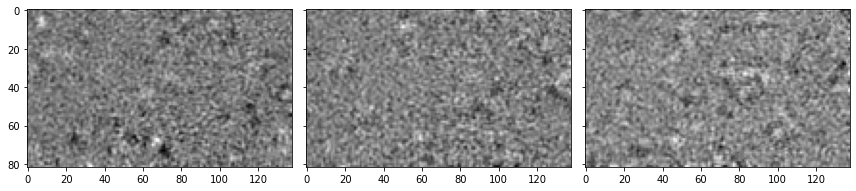


 3600: E = 7.32e+01, genus abs(h).mean, quatile .1 , .9 1102.75 2.4259501710126605e-05 -2.298957236754361e-05 1.903161171156649e-05

 3700: E = 7.26e+01, genus abs(h).mean, quatile .1 , .9 1102.25 2.423029754323202e-05 -2.299170255356121e-05 1.900622176719302e-05

 3800: E = 7.20e+01, genus abs(h).mean, quatile .1 , .9 1101.25 2.419991433928395e-05 -2.2823081423408104e-05 1.881238089430384e-05

 3900: E = 7.15e+01, genus abs(h).mean, quatile .1 , .9 1102.25 2.4182994542950263e-05 -2.2789240659144886e-05 1.8745668421070407e-05

 4000: E = 7.09e+01, genus abs(h).mean, quatile .1 , .9 1102.25 2.4158614551859097e-05 -2.263876835503193e-05 1.8654190079215545e-05

 
 at eval 4000
grad_L1mean = 1.9395e-04
latex_grad_max = 2.4910e-02
m =   0.041 

E = 70.90399932861328
at BFGS iteration 187 and eval 4009,   umin = -1.0003259181976318, umax = 1.0006604194641113


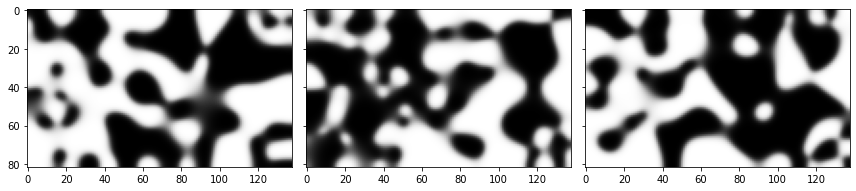

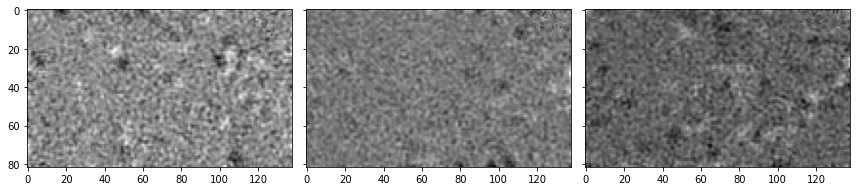

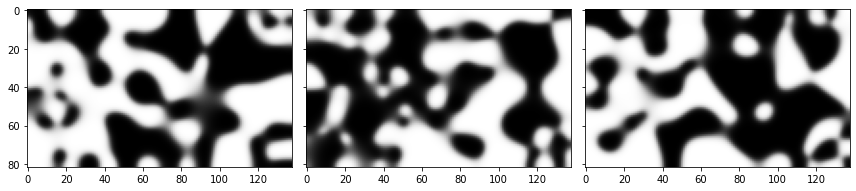

20:23:15 |  DEBUG : vmin 68.35474138899595 vmax 153.34598409229062 
20:23:15 |  DEBUG : ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]) 
20:23:15 |  DEBUG : vmin 68.35474138899595 vmax 153.34598409229062 
20:23:15 |  DEBUG : ticklocs array([2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04]) 
20:23:15 |  DEBUG : vmin 68.35474138899595 vmax 153.34598409229062 
20:23:15 |  DEBUG : ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]) 
20:23:15 |  DEBUG : vmin 68.35474138899595 vmax 153.34598409229062 
20:23:15 |  DEBUG : ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]) 
20:23:15 |  DEBUG : vmin 68.35474138899595 vmax 153.34598409229062 
20:23:15 |  DEBUG : ticklocs array([2.e+

20:23:17 |  DEBUG : ticklocs array([2.e-06, 3.e-06, 4.e-06, 5.e-06, 6.e-06, 7.e-06, 8.e-06, 9.e-06,
       2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05, 9.e-05,
       2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01]) 
20:23:17 |  DEBUG : vmin 7.68335426028784e-05 vmax 0.0022849670530097526 
20:23:17 |  DEBUG : ticklocs array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01]) 
20:23:17 |  DEBUG : vmin 7.68335426028784e-05 vmax 0.0022849670530097526 
20:23:17 |  DEBUG : ticklocs array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01]) 
20:23:17 |  DEBUG : vmin 7.68335426028784e-05 vmax 0.0022849670530097526 
20:23:17 |  DEBUG : ticklocs array([2.e-06, 3.e-06, 4.e-06, 5.e-06, 6.e-06, 7.e-06, 8.e-06, 9.e-06,
       2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.

20:23:18 |  DEBUG : ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]) 
20:23:18 |  DEBUG : vmin 0.0011128018502728646 vmax 0.07908223738065853 
20:23:18 |  DEBUG : ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]) 
20:23:18 |  DEBUG : vmin 0.0011128018502728646 vmax 0.07908223738065853 
20:23:18 |  DEBUG : ticklocs array([2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00]) 
20:23:18 |  DEBUG : vmin 0.0011128018502728646 vmax 0.07908223738065853 
20:23:18 |  DEBUG : ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]) 
20:23:18 |  DEBUG : vmin 0.0011128018502728646 vmax 0.07908223738065853 
20:23:18 |  DEBUG : ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]) 
20:23:18 |

20:23:19 |  DEBUG : vmin 68.35474138899595 vmax 153.34598409229062 
20:23:19 |  DEBUG : ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]) 
20:23:19 |  DEBUG : vmin 68.35474138899595 vmax 153.34598409229062 
20:23:19 |  DEBUG : ticklocs array([2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04]) 
20:23:19 |  DEBUG : vmin 68.35474138899595 vmax 153.34598409229062 
20:23:19 |  DEBUG : ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]) 
20:23:19 |  DEBUG : vmin 0.0011128018502728646 vmax 0.07908223738065853 
20:23:19 |  DEBUG : ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]) 
20:23:19 |  DEBUG : vmin 0.0011128018502728646 vmax 0.07908223738065853 
20:23:19 |  DEBUG : ticklocs a

20:23:20 |  DEBUG : ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]) 
20:23:20 |  DEBUG : vmin 68.35474138899595 vmax 153.34598409229062 
20:23:20 |  DEBUG : ticklocs array([2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04]) 
20:23:20 |  DEBUG : vmin 68.35474138899595 vmax 153.34598409229062 
20:23:20 |  DEBUG : ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]) 
20:23:20 |  DEBUG : vmin 68.35474138899595 vmax 153.34598409229062 
20:23:20 |  DEBUG : ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]) 
20:23:20 |  DEBUG : vmin 68.35474138899595 vmax 153.34598409229062 
20:23:20 |  DEBUG : ticklocs array([2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2

20:23:21 |  DEBUG : ticklocs array([2.e-06, 3.e-06, 4.e-06, 5.e-06, 6.e-06, 7.e-06, 8.e-06, 9.e-06,
       2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05, 9.e-05,
       2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01]) 
20:23:21 |  DEBUG : vmin 7.68335426028784e-05 vmax 0.0022849670530097526 
20:23:21 |  DEBUG : ticklocs array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01]) 
20:23:21 |  DEBUG : vmin 68.35474138899595 vmax 153.34598409229062 
20:23:21 |  DEBUG : ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]) 
20:23:21 |  DEBUG : vmin 68.35474138899595 vmax 153.34598409229062 
20:23:21 |  DEBUG : ticklocs array([2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01

20:23:22 |  DEBUG : vmin 7.68335426028784e-05 vmax 0.0022849670530097526 
20:23:22 |  DEBUG : ticklocs array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01]) 
20:23:22 |  DEBUG : vmin 7.68335426028784e-05 vmax 0.0022849670530097526 
20:23:22 |  DEBUG : ticklocs array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01]) 
20:23:22 |  DEBUG : vmin 7.68335426028784e-05 vmax 0.0022849670530097526 
20:23:22 |  DEBUG : ticklocs array([2.e-06, 3.e-06, 4.e-06, 5.e-06, 6.e-06, 7.e-06, 8.e-06, 9.e-06,
       2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05, 9.e-05,
       2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01]) 
20:23:22 |  DEBUG : vmin 7.68335426028784e-05 vmax 0.0022849670530097526 
20:23:22 |  DEBUG : ticklocs array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,

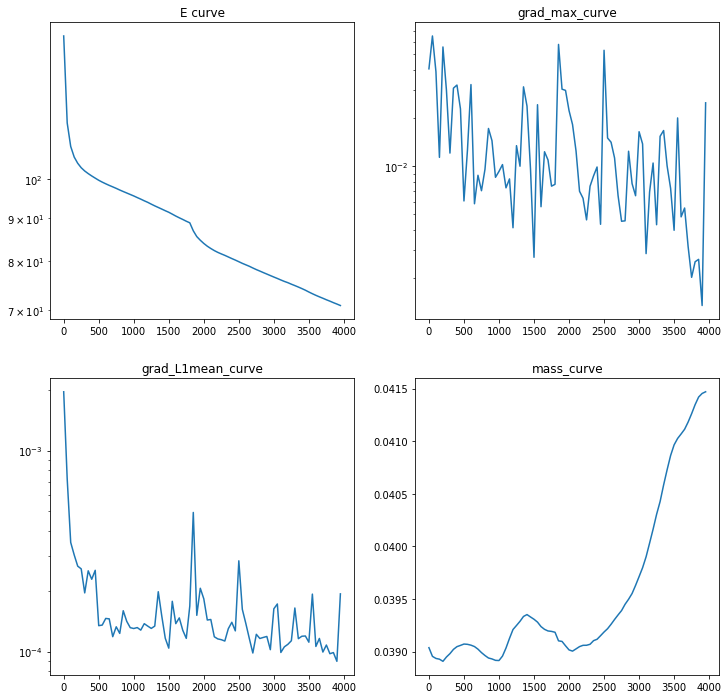


TOTAL DURATION IN SECONDS 918.4586217403412
E = 70.8535
polykap_deg2 bfgs L2 replicate
eps 0.05 coeffs [1, 2, 1, 0, 0, 0]
dx = 0.050 LZ = 3.00 LX = 4.100 LY = 6.900 xi = 1e-06
{'maxeval': 4000, 'sigma_blur': 1, 'lr': 1, 'bfgs_max_iter': 20, 'history_size': 10, 'line_search_fn': 'strong_wolfe', 'display_it_nb': 500, 'fill_curve_nb': 50}


In [263]:

v1 = torch.Tensor(u).contiguous()
u,E = Willmore_flow(v1, maxeval=4000, eps=.05, delta_x=.05, callback=print_quality)

polykap_deg2 bfgs L2 replicate
eps 0.04 coeffs [1, 2, 1, 0, 0, 0]
dx = 0.040, LZ = 2.40, LX = 3.280, LY = 5.520, xi = 1e-06
{'maxeval': 3500, 'sigma_blur': 1, 'lr': 1, 'bfgs_max_iter': 20, 'history_size': 10, 'line_search_fn': 'strong_wolfe', 'display_it_nb': 500, 'fill_curve_nb': 50}

 umin = -1.0000004768371582, umax = 1.0000004768371582
 m =  0.039 

E = 10492.2724609375
at BFGS iteration 1 and eval 25,   umin = -1.0779153108596802, umax = 1.0159316062927246


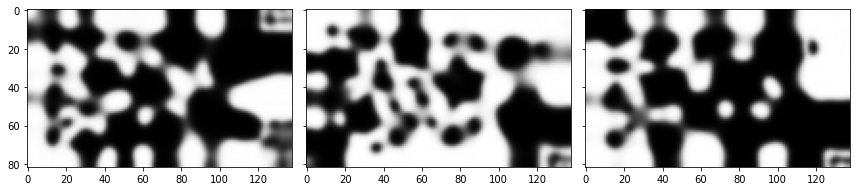

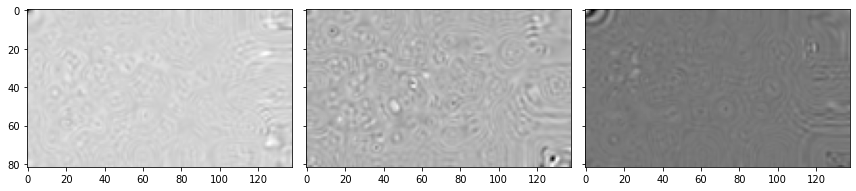


  100: E = 6.03e+02, genus abs(h).mean, quatile .1 , .9 1210.5 5.5432952975956246e-05 -8.829477899239558e-05 6.682454292711696e-05

  200: E = 4.52e+02, genus abs(h).mean, quatile .1 , .9 1166.5 4.905271499576095e-05 -7.554383544509935e-05 5.571488730786043e-05

  300: E = 3.79e+02, genus abs(h).mean, quatile .1 , .9 1150.0 4.52478266581854e-05 -6.776058420634128e-05 5.031280913680377e-05

  400: E = 3.31e+02, genus abs(h).mean, quatile .1 , .9 1138.0 4.26177976266693e-05 -6.174996272807058e-05 4.619137881083883e-05

  500: E = 2.96e+02, genus abs(h).mean, quatile .1 , .9 1133.0 4.0511548567071e-05 -5.6780476413930104e-05 4.2634753730696914e-05

 
 at eval 500
grad_L1mean = 7.1663e-04
latex_grad_max = 7.4378e-02
m =   0.044 

E = 295.5810852050781
at BFGS iteration 24 and eval 509,   umin = -1.0026202201843262, umax = 1.00807523727417


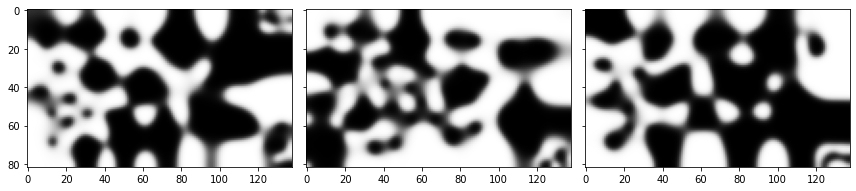

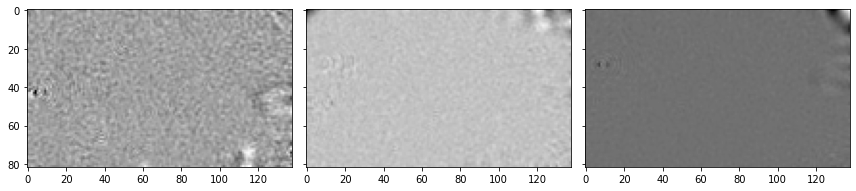


  600: E = 2.69e+02, genus abs(h).mean, quatile .1 , .9 1130.0 3.8932721065631126e-05 -5.354101049598908e-05 4.017562576856547e-05

  700: E = 2.50e+02, genus abs(h).mean, quatile .1 , .9 1129.5 3.762145932929701e-05 -5.078773456705563e-05 3.7748256339938e-05

  800: E = 2.34e+02, genus abs(h).mean, quatile .1 , .9 1123.5 3.6506077659343345e-05 -4.866402470768621e-05 3.59655623740188e-05

  900: E = 2.21e+02, genus abs(h).mean, quatile .1 , .9 1120.0 3.554571781180519e-05 -4.647644175850931e-05 3.428027914682331e-05

 1000: E = 2.09e+02, genus abs(h).mean, quatile .1 , .9 1118.5 3.487975014449296e-05 -4.4939924548920954e-05 3.306457007489497e-05

 
 at eval 1000
grad_L1mean = 4.8882e-04
latex_grad_max = 2.7817e-02
m =   0.041 

E = 209.06373596191406
at BFGS iteration 48 and eval 1018,   umin = -1.0015989542007446, umax = 1.0029385089874268


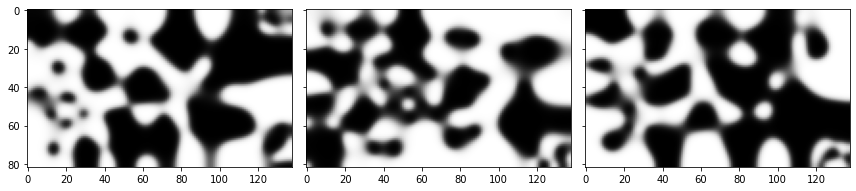

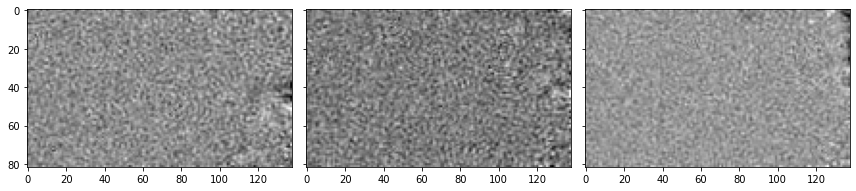


 1100: E = 1.99e+02, genus abs(h).mean, quatile .1 , .9 1122.5 3.407478058808114e-05 -4.339696709313024e-05 3.178845344029441e-05

 1200: E = 1.91e+02, genus abs(h).mean, quatile .1 , .9 1121.5 3.350025207953474e-05 -4.191661481587805e-05 3.1316806563258215e-05

 1300: E = 1.84e+02, genus abs(h).mean, quatile .1 , .9 1125.75 3.293428658925248e-05 -4.054122761556275e-05 3.054399333006506e-05

 1400: E = 1.78e+02, genus abs(h).mean, quatile .1 , .9 1129.75 3.2480771569982514e-05 -3.953521781325219e-05 3.023975320756393e-05

 1500: E = 1.73e+02, genus abs(h).mean, quatile .1 , .9 1130.25 3.20523159116734e-05 -3.883918180315309e-05 2.9662270065138043e-05

 
 at eval 1500
grad_L1mean = 3.8319e-04
latex_grad_max = 1.6716e-02
m =   0.034 

E = 172.6324005126953
at BFGS iteration 71 and eval 1509,   umin = -1.0022481679916382, umax = 1.0028207302093506


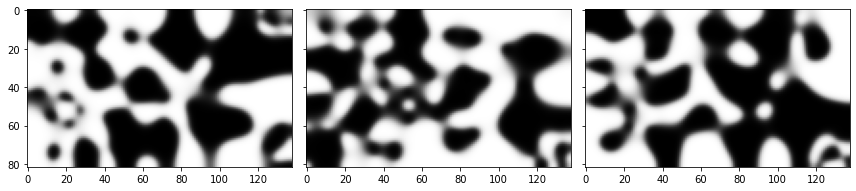

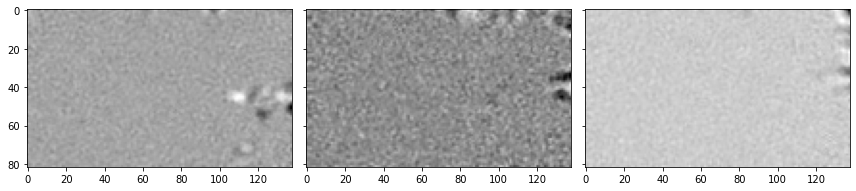


 1600: E = 1.68e+02, genus abs(h).mean, quatile .1 , .9 1123.25 3.1608050180864766e-05 -3.797655974134708e-05 2.9284992626956132e-05

 1700: E = 1.63e+02, genus abs(h).mean, quatile .1 , .9 1126.25 3.1198875900377885e-05 -3.693197077828831e-05 2.8677625150401596e-05

 1800: E = 1.60e+02, genus abs(h).mean, quatile .1 , .9 1124.75 3.089968842631136e-05 -3.6216644969941245e-05 2.8445762749069153e-05

 1900: E = 1.56e+02, genus abs(h).mean, quatile .1 , .9 1127.5 3.065550136697571e-05 -3.565593562767756e-05 2.8087569542541795e-05

 2000: E = 1.53e+02, genus abs(h).mean, quatile .1 , .9 1128.5 3.047149438146451e-05 -3.49121867792747e-05 2.7865466026116794e-05

 
 at eval 2000
grad_L1mean = 2.8068e-04
latex_grad_max = 5.3476e-02
m =   0.031 

E = 152.56866455078125
at BFGS iteration 95 and eval 2021,   umin = -1.0021953582763672, umax = 1.0016744136810303


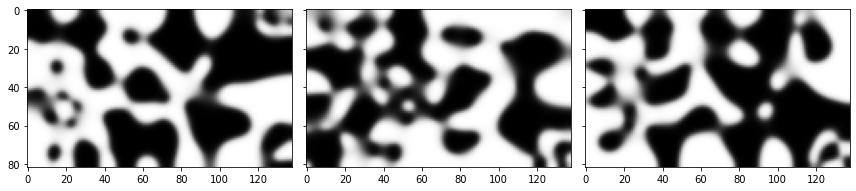

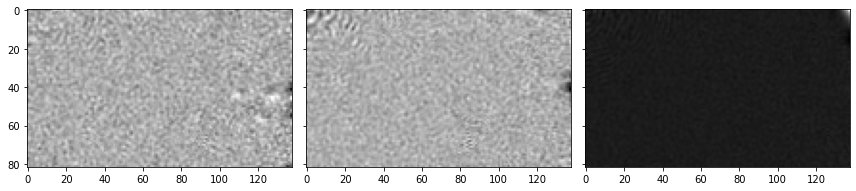


 2100: E = 1.49e+02, genus abs(h).mean, quatile .1 , .9 1129.5 3.0252242024585327e-05 -3.433073795052797e-05 2.753107727769084e-05

 2200: E = 1.46e+02, genus abs(h).mean, quatile .1 , .9 1126.5 3.0025236018918254e-05 -3.372498682773305e-05 2.728420928756403e-05

 2300: E = 1.43e+02, genus abs(h).mean, quatile .1 , .9 1127.0 2.9807610257335633e-05 -3.2978322961934955e-05 2.6941089469091283e-05

 2400: E = 1.40e+02, genus abs(h).mean, quatile .1 , .9 1126.0 2.9596767139668964e-05 -3.2692538569689386e-05 2.6574847416141453e-05

 2500: E = 1.38e+02, genus abs(h).mean, quatile .1 , .9 1129.5 2.940554053230463e-05 -3.2183400378597294e-05 2.629462556848516e-05

 
 at eval 2500
grad_L1mean = 2.2842e-04
latex_grad_max = 3.1514e-02
m =   0.031 

E = 137.82643127441406
at BFGS iteration 118 and eval 2514,   umin = -1.0015640258789062, umax = 1.003077507019043


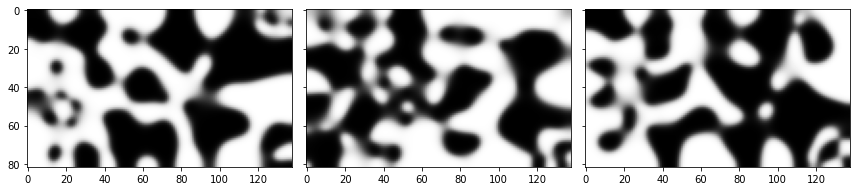

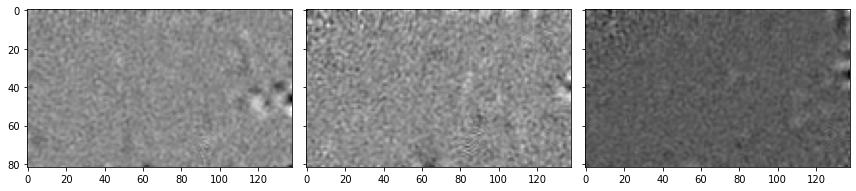


 2600: E = 1.35e+02, genus abs(h).mean, quatile .1 , .9 1129.5 2.914486512963846e-05 -3.148517437396077e-05 2.5967405507320828e-05

 2700: E = 1.33e+02, genus abs(h).mean, quatile .1 , .9 1127.5 2.8893625921473112e-05 -3.114429962843376e-05 2.5550418604539494e-05

 2800: E = 1.31e+02, genus abs(h).mean, quatile .1 , .9 1131.0 2.8683657366057293e-05 -3.0489901321334973e-05 2.519061300713084e-05

 2900: E = 1.28e+02, genus abs(h).mean, quatile .1 , .9 1130.0 2.8577541912277897e-05 -3.019795287790241e-05 2.5031685793688454e-05

 3000: E = 1.26e+02, genus abs(h).mean, quatile .1 , .9 1129.5 2.8409603540522123e-05 -2.9974239723180625e-05 2.464255523204918e-05

 
 at eval 3000
grad_L1mean = 1.9431e-04
latex_grad_max = 2.8610e-02
m =   0.032 

E = 126.1528549194336
at BFGS iteration 141 and eval 3004,   umin = -1.0014928579330444, umax = 1.0015536546707153


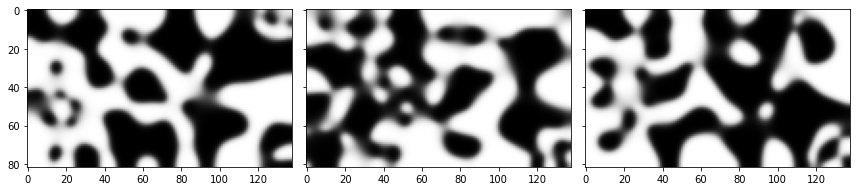

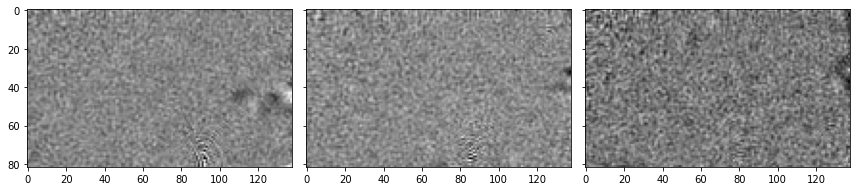


 3100: E = 1.24e+02, genus abs(h).mean, quatile .1 , .9 1133.5 2.8221246646544764e-05 -2.951664876522257e-05 2.432685662439705e-05

 3200: E = 1.22e+02, genus abs(h).mean, quatile .1 , .9 1130.0 2.806499399286437e-05 -2.9214561626140703e-05 2.418933999137703e-05

 3300: E = 1.20e+02, genus abs(h).mean, quatile .1 , .9 1128.5 2.790205782176792e-05 -2.8824293150712175e-05 2.41202401379742e-05

 3400: E = 1.18e+02, genus abs(h).mean, quatile .1 , .9 1124.0 2.7804681830771175e-05 -2.8683336618043308e-05 2.4012290789602504e-05

 3500: E = 1.17e+02, genus abs(h).mean, quatile .1 , .9 1122.0 2.771511038810841e-05 -2.846905727666652e-05 2.363718592553061e-05

 
 at eval 3500
grad_L1mean = 1.6255e-04
latex_grad_max = 1.3903e-02
m =   0.034 

E = 116.76596069335938
at BFGS iteration 165 and eval 3517,   umin = -1.0008339881896973, umax = 1.0014138221740723


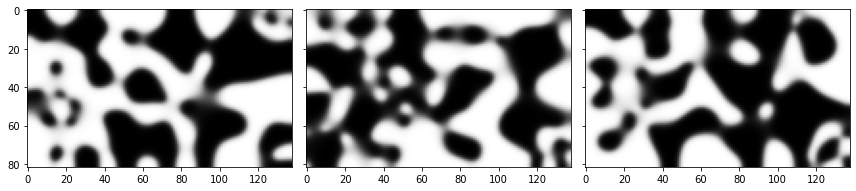

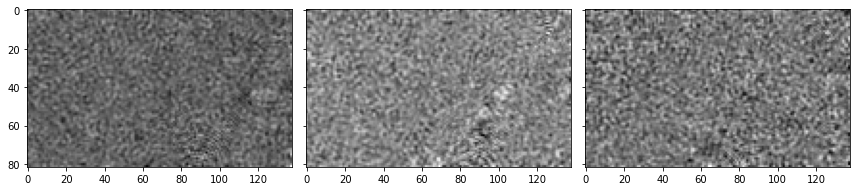

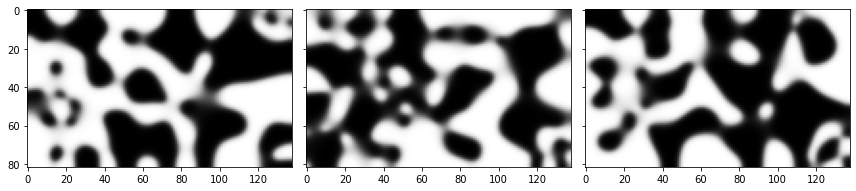

21:23:15 |  DEBUG : vmin 105.86948825169867 vmax 917.1038631150358 
21:23:15 |  DEBUG : ticklocs array([   10.,   100.,  1000., 10000.]) 
21:23:15 |  DEBUG : vmin 105.86948825169867 vmax 917.1038631150358 
21:23:15 |  DEBUG : ticklocs array([2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04]) 
21:23:15 |  DEBUG : vmin 105.86948825169867 vmax 917.1038631150358 
21:23:15 |  DEBUG : ticklocs array([   10.,   100.,  1000., 10000.]) 
21:23:15 |  DEBUG : vmin 105.86948825169867 vmax 917.1038631150358 
21:23:15 |  DEBUG : ticklocs array([   10.,   100.,  1000., 10000.]) 
21:23:15 |  DEBUG : vmin 105.86948825169867 vmax 917.1038631150358 
21:23:15 |  DEBUG : ticklocs array([2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+

21:23:16 |  DEBUG : vmin 0.00013955011991162585 vmax 0.00400061398881971 
21:23:16 |  DEBUG : ticklocs array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01]) 
21:23:16 |  DEBUG : vmin 0.00013955011991162585 vmax 0.00400061398881971 
21:23:16 |  DEBUG : ticklocs array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01]) 
21:23:16 |  DEBUG : vmin 0.00013955011991162585 vmax 0.00400061398881971 
21:23:16 |  DEBUG : ticklocs array([2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05, 9.e-05,
       2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01]) 
21:23:16 |  DEBUG : vmin 0.00013955011991162585 vmax 0.00400061398881971 
21:23:16 |  DEBUG : ticklocs array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01]) 
21:23:16 |  DEBUG : vmin 105.86948825169867 vmax 917.1038631150358 
21:23:16 |  DEBU

21:23:16 |  DEBUG : vmin 0.005375480328828657 vmax 0.43356821436412274 
21:23:16 |  DEBUG : ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]) 
21:23:16 |  DEBUG : vmin 0.005375480328828657 vmax 0.43356821436412274 
21:23:16 |  DEBUG : ticklocs array([2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01]) 
21:23:16 |  DEBUG : vmin 0.005375480328828657 vmax 0.43356821436412274 
21:23:16 |  DEBUG : ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]) 
21:23:16 |  DEBUG : vmin 0.005375480328828657 vmax 0.43356821436412274 
21:23:16 |  DEBUG : ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]

21:23:17 |  DEBUG : vmin 0.005375480328828657 vmax 0.43356821436412274 
21:23:17 |  DEBUG : ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]) 
21:23:17 |  DEBUG : vmin 0.005375480328828657 vmax 0.43356821436412274 
21:23:17 |  DEBUG : ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]) 
21:23:17 |  DEBUG : vmin 0.005375480328828657 vmax 0.43356821436412274 
21:23:17 |  DEBUG : ticklocs array([2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01]) 
21:23:17 |  DEBUG : vmin 0.005375480328828657 vmax 0.43356821436412274 
21:23:17 |  DEBUG : ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]

21:23:17 |  DEBUG : vmin 105.86948825169867 vmax 917.1038631150358 
21:23:17 |  DEBUG : ticklocs array([   10.,   100.,  1000., 10000.]) 
21:23:17 |  DEBUG : vmin 0.005375480328828657 vmax 0.43356821436412274 
21:23:17 |  DEBUG : ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]) 
21:23:17 |  DEBUG : vmin 0.005375480328828657 vmax 0.43356821436412274 
21:23:17 |  DEBUG : ticklocs array([2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01]) 
21:23:17 |  DEBUG : vmin 0.005375480328828657 vmax 0.43356821436412274 
21:23:17 |  DEBUG : ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]) 
21:23:17 |  DEBUG

21:23:17 |  DEBUG : ticklocs array([   10.,   100.,  1000., 10000.]) 
21:23:17 |  DEBUG : vmin 105.86948825169867 vmax 917.1038631150358 
21:23:17 |  DEBUG : ticklocs array([2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04]) 
21:23:17 |  DEBUG : vmin 105.86948825169867 vmax 917.1038631150358 
21:23:17 |  DEBUG : ticklocs array([   10.,   100.,  1000., 10000.]) 
21:23:17 |  DEBUG : vmin 105.86948825169867 vmax 917.1038631150358 
21:23:17 |  DEBUG : ticklocs array([   10.,   100.,  1000., 10000.]) 
21:23:17 |  DEBUG : vmin 105.86948825169867 vmax 917.1038631150358 
21:23:17 |  DEBUG : ticklocs array([2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5

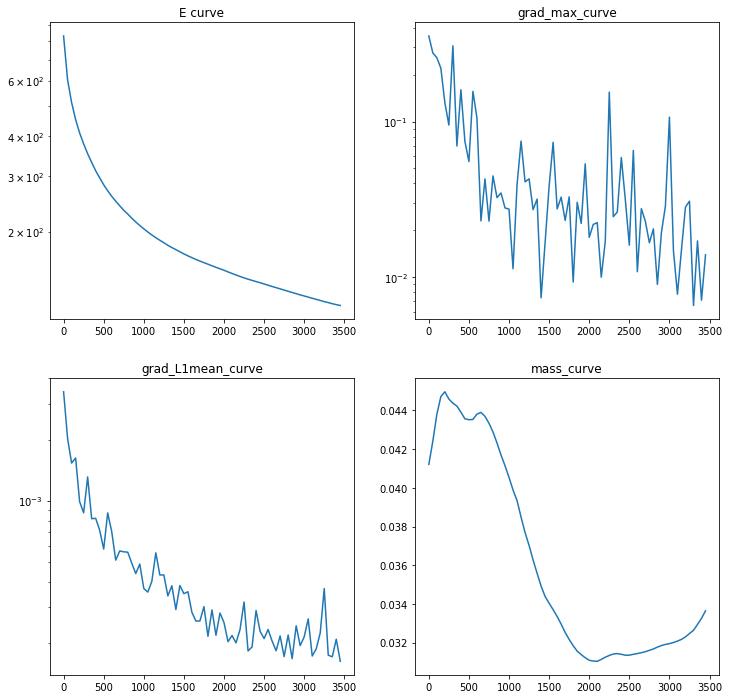


TOTAL DURATION IN SECONDS 740.0755553245544
E = 116.5197
polykap_deg2 bfgs L2 replicate
eps 0.04 coeffs [1, 2, 1, 0, 0, 0]
dx = 0.040 LZ = 2.40 LX = 3.280 LY = 5.520 xi = 1e-06
{'maxeval': 3500, 'sigma_blur': 1, 'lr': 1, 'bfgs_max_iter': 20, 'history_size': 10, 'line_search_fn': 'strong_wolfe', 'display_it_nb': 500, 'fill_curve_nb': 50}


In [267]:
# Find a point of convergence of the flow ~ wait for 
# note: setting a smaller learning rate to optim_props of BFGS in Willmore_flow() improves the precision

u,E = Willmore_flow(v0, maxeval=3500, eps=.04, delta_x=.04) # maxeval = 1000 in the paper


20:24:04 |  DEBUG : colorbar update normal <matplotlib.colors.Normalize object at 0x7fbce02070d0> <matplotlib.colors.Normalize object at 0x7fbce02070d0> 
20:24:04 |  DEBUG : colorbar update normal <matplotlib.colors.Normalize object at 0x7fbce02070d0> <matplotlib.colors.Normalize object at 0x7fbce02070d0> 
20:24:04 |  DEBUG : locator: <matplotlib.ticker.AutoLocator object at 0x7fbcd7f86220> 
20:24:04 |  DEBUG : locator: <matplotlib.ticker.AutoLocator object at 0x7fbcd7f86220> 
20:24:04 |  DEBUG : locator: <matplotlib.ticker.AutoLocator object at 0x7fbcd7f86ac0> 


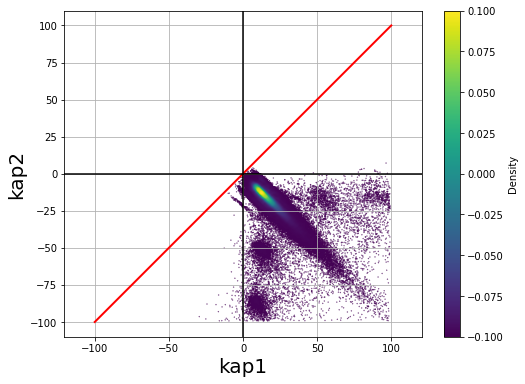

20:24:22 |  INFO : use_dfenv True 
20:24:22 |  INFO : dfenv used without any rotation. Rotation Matrix set to None. 
20:24:23 |  INFO : Function compute_contours finished. Execution time 0.22858095169067383s 
20:24:23 |  WARNING : no cut_twice possible increase GROW_BB_DISTANCE please 
20:24:23 |  INFO : Function get_inside_cells finished. Execution time 0.006165266036987305s 
20:24:26 |  INFO : Function collect_stats_open_mesh finished. Execution time 2.959383726119995s 
20:24:26 |  INFO : {'area': 26408.744298733105, 'genus': 145, 'number_of_components': 1, 'neg_gauss_normalized': 0.940943321442727, 'sum_positive_gauss': 53.574942825392924, 'mean_q10': -0.12146149259296471, 'mean_q90': 0.12036647246175963} 
20:24:37 |  INFO : random point estimation of volume percentage 0.43213 
20:24:37 |  DEBUG : Saving variable contour using function __save_contour 
20:24:39 |  INFO : File /home/jovyan/OUTPUT/box_test/mirror_add__7380/7380_550_contour.obj was saved. 
20:24:39 |  INFO : [TimeTracke

In [264]:
plot_curvature_diagram(u)
anal(u)
import wtv.tvtk_curvatures 
k1, k2 = wtv.tvtk_curvatures.get_curvature_radii(vh.smooth_surface)
print(np.sum(np.abs(k1 + k2)/len(k1)))

In [168]:
{'area': 25695.343507669095, 'genus': 216, 'number_of_components': 1, 'neg_gauss_normalized': 0.9996217747068754, 'sum_positive_gauss': 0.0018424028509321554, 'mean_q10': -0.039248963568438267, 'mean_q90': 0.040778214004743185} 
{'area': 25749.7164289955, 'genus': 213, 'number_of_components': 1, 'neg_gauss_normalized': 0.9996156204526527, 'sum_positive_gauss': 0.00249380321914092, 'mean_q10': -0.039917719605869595, 'mean_q90': 0.04140892460118194} 
{'area': 25725.803933194697, 'genus': 209, 'number_of_components': 1, 'neg_gauss_normalized': 0.999579647635061, 'sum_positive_gauss': 0.002756076517302239, 'mean_q10': -0.04130878885242436, 'mean_q90': 0.04291152522373627} 
{'area': 25747.330797942017, 'genus': 213, 'number_of_components': 1, 'neg_gauss_normalized': 0.9995787391479541, 'sum_positive_gauss': 0.0024118502779065538, 'mean_q10': -0.04310854382762057, 'mean_q90': 0.041599724679480726} 
{'area': 25756.33022518576, 'genus': 211, 'number_of_components': 1, 'neg_gauss_normalized': 0.9996074099097043, 'sum_positive_gauss': 0.002340084360268003, 'mean_q10': -0.04211506620845987, 'mean_q90': 0.04339646268874804} 
{'area': 25809.129799000144, 'genus': 223, 'number_of_components': 1, 'neg_gauss_normalized': 0.9995161982309286, 'sum_positive_gauss': 0.0049760563253197325, 'mean_q10': -0.04246655752760881, 'mean_q90': 0.04184478158378376} 

(3.758368241788357e-06, 3.890721475090925e-06, 3.178171388705864e-06)

In [236]:
{'area': 25524.60242685368, 'genus': 207, 'number_of_components': 1, 'neg_gauss_normalized': 0.9995226993189287, 'sum_positive_gauss': 0.0019189291725015478,
 'mean_q10': -0.04531076640617733, 'mean_q90': 0.04261630786365071} 
24000:
    {'area': 25715.309959616352, 'genus': 207, 'number_of_components': 1, 'neg_gauss_normalized': 0.999442484508381, 'sum_positive_gauss': 0.010618842200974967, 
     'mean_q10': -0.0456966230690355, 'mean_q90': 0.0397127363686762} 
INFO : {'area': 25798.458885399235, 'genus': 225, 'number_of_components': 1, 'neg_gauss_normalized': 0.9995439038184373, 'sum_positive_gauss': 0.013392435340387239,
        'mean_q10': -0.04376716717687351, 'mean_q90': 0.0404097399778347} 
INFO : {'area': 25801.506608369367, 'genus': 236, 'number_of_components': 1, 'neg_gauss_normalized': 0.9994599196287176, 'sum_positive_gauss': 0.007415157480819205,
        'mean_q10': -0.04299864102525371, 'mean_q90': 0.04002380213373419} 
{'area': 25498.237079663577, 'genus': 232, 'number_of_components': 1, 'neg_gauss_normalized': 0.9995225020890534, 'sum_positive_gauss': 0.00282183823760857,
 'mean_q10': -0.046880484867727557, 'mean_q90': 0.042717931023969646} 
20:54:41 |  INFO : {'area': 23646.370614571566, 'genus': 167, 'number_of_components': 1, 'neg_gauss_normalized': 0.9990652567622831, 'sum_positive_gauss': 0.06434838236780811,
                    'mean_q10': -0.052795041508017046, 'mean_q90': 0.04006473017585883} 
anz  = 1000

.5
INFO : {'area': 25543.116968926213, 'genus': 245, 'number_of_components': 1, 'neg_gauss_normalized': 0.999480949952648, 'sum_positive_gauss': 0.007362105226141957, 
        'mean_q10': -0.05318810530915405, 'mean_q90': 0.043782217548835066} 
.4
20:31:40 |  INFO : {'area': 25702.038966985478, 'genus': 242, 'number_of_components': 1, 'neg_gauss_normalized': 0.9993941257324749, 'sum_positive_gauss': 0.24021342626124192, 
                    'mean_q10': -0.04606478571243347, 'mean_q90': 0.051213037906833216} 
.6
{'area': 25439.979773882274, 'genus': 242, 'number_of_components': 1, 'neg_gauss_normalized': 0.9993419910254887, 'sum_positive_gauss': 24.64755741966859, 
 'mean_q10': -0.044564896156208005, 'mean_q90': 0.05321680060435652} 
.25
19:54:16 |  INFO : {'area': 26311.722963691755, 'genus': 245, 'number_of_components': 1, 'neg_gauss_normalized': 0.9995241619964048, 'sum_positive_gauss': 0.004584508971259934, 
                    'mean_q10': -0.05185220396182421, 'mean_q90': 0.04902394192124778} 
.3
            18:18:50 |  INFO : {'area': 25993.277238397448, 'genus': 276, 'number_of_components': 1, 'neg_gauss_normalized': 0.999392157038017, 
                    'sum_positive_gauss': 10.21044836405667, 'mean_q10': -0.04701484591675992, 'mean_q90': 0.05139304163501354} 
#*.5 before clipping much betterè!

#18:00:38 |  INFO : {'area': 25520.022410350226, 'genus': 233, 'number_of_components': 1, 'neg_gauss_normalized': 0.9996327208954264, 
'sum_positive_gauss': 0.0013799505209653715, 'mean_q10': -0.04472674406844772, 'mean_q90': 0.0441919321430425} 
#more clipping
#7:49:49 |  INFO : {'area': 25309.366523738863, 'genus': 222, 'number_of_components': 1, 'neg_gauss_normalized': 0.9994455892000776, 'sum_positive_gauss': 0.0026579899155454306, 'mean_q10': -0.04756332390745244, 'mean_q90': 0.039386986678883816} #STEPS = 4000 u,E = Willmore_flow(v0, maxeval = 2000, eps=.04, delta_x=.04) 
#17:03:28 |  INFO : {'area': 25340.48130364671, 'genus': 243, 'number_of_components': 1, 'neg_gauss_normalized': 0.9995566843685061, 'sum_positive_gauss': 0.010462764969195106, 'mean_q10': -0.048725508490771154, 'mean_q90': 0.03858670562631545} 
#STEPS = 2000 u,E = Willmore_flow(v0, maxeval = 2000, eps=.04, delta_x=.04) 
#16:48:57 |  INFO : {'area': 25340.123571328906, 'genus': 242, 'number_of_components': 1, 'neg_gauss_normalized': 0.9995123566972747, 'sum_positive_gauss': 0.010893050118234866, 'mean_q10': -0.052284746354762546, 'mean_q90': 0.03969746554959386} 
#steps 15000
#INFO : {'area': 25481.542169895765, 'genus': 263, 'number_of_components': 1, 'neg_gauss_normalized': 0.9996031526293445, 'sum_positive_gauss': 0.0032389105425905626, 'mean_q10': -0.04368030247316586, 'mean_q90': 0.043377929865779374} 
            
#1500 steps!
#15:28:21 |  INFO : {'area': 25434.4897391457, 'genus': 286, 'number_of_components': 1, 'neg_gauss_normalized': 0.9992925005053568, 'sum_positive_gauss': 0.009820804993793744, 'mean_q10': -0.05474592932839496, 'mean_q90': 0.054220947744614396} 
#u,E = Willmore_flow(v0, maxeval = 500, eps=.03, delta_x=.034) 
#15:22:06 |  INFO : {'area': 25290.532617449502, 'genus': 279, 'number_of_components': 1, 'neg_gauss_normalized': 0.9993849260993298, 'sum_positive_gauss': 0.009639634116311763, 'mean_q10': -0.0682165863053163, 'mean_q90': 0.0639575033399151} 
#u,E = Willmore_flow(v0, maxeval = 500, eps=.06, delta_x=.034)
#15:18:46 |  INFO : {'area': 22051.94100519362, 'genus': 118, 'number_of_components': 1, 'neg_gauss_normalized': 0.9979576048274795, 'sum_positive_gauss': 286.96528872007787, 'mean_q10': -0.04083516493951759, 'mean_q90': 0.0592231572598647} 
#u,E = Willmore_flow(v0, maxeval = 500, eps=.06, delta_x=.05)
#15:09:33 |  INFO : {'area': 24769.443874136457, 'genus': 219, 'number_of_components': 1, 'neg_gauss_normalized': 0.9994654512716633, 'sum_positive_gauss': 0.007781758635039871, 'mean_q10': -0.056653883728102525, 'mean_q90': 0.03939851500287221} 
#u,E = Willmore_flow(v0, maxeval = 4500, eps=.06, delta_x=.05)
#15:02:18 |  INFO : {'area': 24743.243043956027, 'genus': 178, 'number_of_components': 1, 'neg_gauss_normalized': 0.9990941516163732, 'sum_positive_gauss': 0.023137605891475718, 'mean_q10': -0.043417949369982556, 'mean_q90': 0.040432467641747655} 
#14:49:53 |  INFO : {'area': 24083.75795758553, 'genus': 177, 'number_of_components': 1, 'neg_gauss_normalized': 0.9986047630502767, 'sum_positive_gauss': 1150.540798537207, 'mean_q10': -0.0439476713678175, 'mean_q90': 0.04642481697704434} 
#4:35:07 |  INFO : {'area': 24698.248144358582, 'genus': 193, 'number_of_components': 1, 'neg_gauss_normalized': 0.9993191231819644, 'sum_positive_gauss': 0.007062529991203028, 'mean_q10': -0.04642952302356363, 'mean_q90': 0.0414
gms = {}
gms["SmoothSurface"] = tvtk.to_vtk(vh.clipped_smooth_surface)
view(geometries=gms)

SyntaxError: invalid syntax (<ipython-input-236-2939c07bbc9f>, line 3)

In [265]:
gms = {}
gms["SmoothSurface"] = tvtk.to_vtk(vh.clipped_smooth_surface)
view(geometries=gms)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [42]:
np.save("../../../OUTPUT/box_test/u.npy", u)
from itkwidgets import view;view(u)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

In [86]:
import wtv.tvtk_curvatures
k1, k2 = wtv.tvtk_curvatures.get_curvature_radii(vh.smooth_surface)
print(np.quantile((k1 + k2)*.5,.9), np.quantile((k1 + k2)*.5,.1))


0.054220947744614396 -0.05474592932839496


In [48]:
model_input_path = ""  # /home/jovyan/INPUT/...
output_path = ""  # /home/jovyan/OUTPUT/...
path_to_ini = ""  # /home/jovyan/INPUT/...ini # If empty then not loaded
path_to_stress = ""  # /home/jovyan/INPUT/...
load_all_visualizations = False

import numpy as np
from IPython.display import display
from itkwidgets import view, Viewer  ## 3D viewer
from tvtk.api import tvtk
from context import context_manager

from api import pipeline
from functions import utilities
from context import variable_handler
from functions import visualisation_functions
vh = variable_handler.VariableHandler()
utilities.setup(
    vh,
    path_to_ini=path_to_ini,
    model_input_path=model_input_path,
    output_path=output_path,
    path_to_stress=path_to_stress,
)

used_tweaks, used_case_config = vh.custom_tweaks, vh.used_case_config

# MODIFY TWEAKS HERE

# used_case_config.SHAPE_NAME = "cylinder" # this name is taken for output folder with results
# used_case_config.COMPONENT_NAME = "27x40" #in input folder should be {component_name}_env.ply (27x40_env.ply)


# ### use infill mode
# used_case_config.INFILL_MODE = True # default is False
# used_case_config.INFILL_ENVELOPE_THICKNESS = 1.0
# used_case_config.INFILL_ENVELOPE_VOXEL_SIZE = 1.5

used_case_config.GENERATE_CLIPPED_SMOOTH_SURFACE = True
used_case_config.SHAPE_NAME = "box_test" # this name is taken for output folder with results
used_case_config.COMPONENT_NAME = "mirror_add" #in input folder should be {component_name}_env.ply (27x40_env.ply)

# used_case_config.MIN_CHANNEL = 0.5
# used_case_config.MAX_CHANNEL = 2.0
# used_case_config.MIN_WALL = 0.22
# used_case_config.MAX_WALL = 0.33
# used_case_config.NORMAL_ENV = True
# if you do not want to provide dfenv
#used_case_config.CALC_DFENV = False
#used_case_config.VOXEL_SIZE_DFENV = 8  # can be quite huge
#used_case_config.OFFSET_DFENV = 4
# Actually normal_env= False is more natural. True means df_env for scattering
# used_case_config.ROT_ENV = False #use the boundingbox method to compute the rotated envelope (so that the envelope aligns the boundingbox)
# used_case_config.RANDOM_SEED = 30 # If None -  Just complete randomness. Otherwise, seed is set. Has to be of type integer.
# used_case_config.RUNTIME_NUMBER = None  # If None - New runtime number is created. If set, already existing folder is used

#

# ### If you want to use heuristics, enable it:
# used_tweaks.USE_HEURISTIC = True # default values is False
# used_tweaks.NAME_OF_HEURISTIC = "naive"
# ### call heuristics
# import heuristics
# heuristics.apply_heuristics(vh)
#
#
# ### Bounding Box tweaks for rotation:
# used_tweaks.boundingbox_tweaks.BB_METHOD = 'pca' #choose the method to rotate the boundingbox
# used_tweaks.boundingbox_tweaks.GRIDSEARCH_STEPS = 220 #In case the method "best" or "gridseach" is used, this is the number of steps to perform in the gridsearch algorithm.


# STOP MODIFICATION HERE

utilities.prepare_to_execute(
    vh,
    model_input_path=model_input_path,
    output_path=output_path,
    path_to_stress=path_to_stress,
)


if load_all_visualizations:
    pipeline.load_results_for_visualization(vh)

if vh.is_infill_mode():
    pipeline.calculate_offset_for_infill(vh)
elif vh.used_case_config.CALC_DFENV:
    vh.dfenv_tvtk = vh.calc_defeatured_envelope()
else:
    if not hasattr(vh, "dfenv_tvtk"):
        raise RuntimeError("no dfenv_tvtk defined.")
vh.init_validation_variable_handler()
vh.custom_tweaks.surface_tweaks.POTENTIAL_FIELD_VOXEL_SIZE = 0.6

14:33:43 |  DEBUG : assemble_input_path /home/jovyan/INPUT/, box_test, mirror_add 
14:33:43 |  INFO : Models (Envelopes, Boundary-Conditions) are loaded from /home/jovyan/INPUT/box_test/mirror_add/ 
14:33:43 |  INFO : Results are saved and loaded from folder /home/jovyan/OUTPUT/box_test/mirror_add__7380/. 
14:33:43 |  DEBUG : Call heuristics from initialization step. 
14:33:43 |  INFO : The heuristic is turn off. If you want to use heuristic, set a flag tweaks.USE_HEURISTIC to True and specify tweaks.NAME_OF_HEURISTIC 
14:33:43 |  DEBUG : Reading file from /home/jovyan/INPUT/box_test/mirror_add/mirror_add_env.obj. 
14:33:43 |  WARNING : load_ply_obj_stl function was used for /home/jovyan/INPUT/box_test/mirror_add/mirror_add_dfenv but nothing was loaded 
14:33:43 |  INFO : No dfenv found. Using env as dfenv! 
14:33:43 |  INFO : Parameters of case_config are valid. 
14:33:43 |  INFO : Parameters of all tweaks are valid. 
14:33:43 |  INFO : Function get_statistics_closed_vtk finished. Exe

In [245]:
# MODIFY TWEAKS FOR smooth_contour STEP:
from context import tweaks

if True: #TriMeshNeckpinchSmoothing
    vh.custom_tweaks.smoothing_tweaks = tweaks.SmoothingTrimeshNeckpinch()
    vh.custom_tweaks.smoothing_tweaks.NUM_STEPS_BEFORE = 73 #to make smooth boundaries (laplace is only active in these steps!)
    vh.custom_tweaks.smoothing_tweaks.NUM_ITERATIONS =3
    vh.custom_tweaks.smoothing_tweaks.NUM_STEPS_PER_ITERATION = 210 #num steps without neckpinch control
    vh.custom_tweaks.smoothing_tweaks.BAD_TRIANGLE_MAX_ANGLE = 2.4 #detect long triangles maximal angle given in radians
    vh.custom_tweaks.smoothing_tweaks.NUM_STEPS_FINAL = 35   #too smooth out after last neckpinch blowup
    vh.custom_tweaks.smoothing_tweaks.RELAXATION_FACTOR = .5 #step size
elif False:  #optimesh smoothing
    vh.custom_tweaks.smoothing_tweaks = tweaks.SmoothingOptimeshTweaks()
    vh.custom_tweaks.smoothing_tweaks.NUM_STEPS_BEFORE_CUT = 2 #to make smooth boundaries (laplace is only active in these steps!)
    vh.custom_tweaks.smoothing_tweaks.NUM_STEPS_AFTER_CUT = 4 #smoohting steps on the cutted surface
    vh.custom_tweaks.smoothing_tweaks.NUM_FINAL_STEPS = 4 #num steps without neckpinch control
    vh.custom_tweaks.smoothing_tweaks.TUNNEL_DISTANCE = 1.5 #necks smaller than this will be hold fixed
    vh.custom_tweaks.smoothing_tweaks.LAPLACE_FACTOR = .05 #a bit of laplacian smoothing is needed for the first few iterations should be small iff some peaks do not vanish increase
    vh.custom_tweaks.smoothing_tweaks.REDUCTION_FACTOR1 = .3 #reduce the mesh by this factor before smoothing
    vh.custom_tweaks.smoothing_tweaks.REDUCTION_FACTOR2 = 0   #reduce the mesh by this factor after cut
    vh.custom_tweaks.smoothing_tweaks.ANZ_IT_CALLBACK = 2    #the necks are not calculated in every iteration but in every anz_it_callback
    vh.custom_tweaks.smoothing_tweaks.OMEGA = 1.6 #overrelaxation step_factor 1 < omega < 2

# STOP MODIFICATION HERE

In [19]:

def anal(u):
    vh.force_field = u
    pipeline.create_contour(vh)
    pipeline.smooth_contour(vh)
    
    
anal(u)

13:43:11 |  INFO : use_dfenv True 
13:43:11 |  INFO : dfenv used without any rotation. Rotation Matrix set to None. 
13:43:11 |  INFO : Function compute_contours finished. Execution time 0.07827043533325195s 
13:43:11 |  INFO : OffsetSurface voxelsize=0.6 
setting bounding_Box to BoundingBox(((-9.461927890777588, -18.018463134765625, -3.0),(27.103452682495117, 31.614818572998047, 79.2314682006836)))
13:43:11 |  DEBUG : number of thread 14 
13:43:11 |  DEBUG : sample_dims[60, 82, 137] 
13:43:11 |  INFO : [ 60  82 137] 
13:43:12 |  DEBUG : Change file path from relative distance_field.vti to absolute, using the output folder /home/jovyan/OUTPUT/box_test/mirror_add__4991/ 
13:43:12 |  INFO : File /home/jovyan/OUTPUT/box_test/mirror_add__4991/distance_field.vti was saved. 
13:43:12 |  INFO : ImplicitFunction done in 0.266211 
13:43:12 |  DEBUG : size distance_values 2.69616 MB 
13:43:12 |  INFO : no distance_mult_field found 
13:43:12 |  INFO : done 
13:43:15 |  INFO : Function get_inside_

In [50]:
import sys
print(sys.path)
vh.custom_tweaks.surface_tweaks.POTENTIAL_FIELD_VOXEL_SIZE = 0.6
vh.force_field = u
print(vh.custom_tweaks.surface_tweaks)
pipeline.create_contour(vh)
#pipeline.smooth_contour(vh)

['/home/jovyan/work/curvatubes/notebooks', '/home/jovyan/work/curvatubes/notebooks', '/app/src/python/spongify/src', '/opt/conda/lib/python38.zip', '/opt/conda/lib/python3.8', '/opt/conda/lib/python3.8/lib-dynload', '', '/opt/conda/lib/python3.8/site-packages', '/opt/conda/lib/python3.8/site-packages/pymesh2-0.3-py3.8-linux-x86_64.egg', '/opt/conda/lib/python3.8/site-packages/IPython/extensions', '/home/jovyan/.ipython', '/home/jovyan/work/curvatubes', '/opt/conda/lib/python3.8/site-packages/pymesh2-0.3-py3.8-linux-x86_64.egg/pymesh/lib']
surface_tweaks:
	CHARGE_RATIO : 1.0
	CUT_TWICE : True
	FILTER_SIGMA : 0.2
	GROW_BB_DISTANCE : 2.4
	ISO_VALUES : False
	KEEP_UNCONNECTED : False
	NUM_POINTS_FOR_POTENTIAL_CALCULATION : 100
	NUM_POINTS_FOR_VOLUME_RATIO_ESTIMATION : 100000.0
	POTENTIAL_FIELD_VOXEL_SIZE : 0.6
	SHRINK_FACTOR_FOR_VOLUME_RATIO_ESTIMATION : 0.8
	STEP_MULT_GRAPH : 0.1
14:33:49 |  INFO : use_dfenv True 
14:33:49 |  INFO : dfenv used without any rotation. Rotation Matrix set to 

In [ ]:

14:19:05 |  INFO : Function get_inside_cells finished. Execution time 4.577979803085327s 
14:19:06 |  INFO : Function collect_stats_open_mesh finished. Execution time 1.0362632274627686s 
14:19:06 |  INFO : {'area': 7534.192239398698, 'genus': 239, 'number_of_components': 1, 'neg_gauss_normalized': 0.9459988741506576, 'sum_positive_gauss': 1083.3433651155967, 'mean_q10': -0.30106370781722985, 'mean_q90': 0.30013147440320836} 
14:19:10 |  INFO : random point estimation of volume percentage 0.65075 
14:19:10 |  DEBUG : Saving variable contour using function __save_contour 
14:19:11 |  INFO : File /home/jovyan/OUTPUT/box_test/mirror_add__4991/4991_550_contour.obj was saved. 
14:19:11 |  INFO : [RAMTracker] function: create_contour : 5071 
14:19:11 |  INFO : [TimeTracker] function: create_contour : 10.59 
14:19:11 |  INFO : Statistics not saved for the following : contour 
14:19:11 |  INFO : Performance statistics not saved for the following : contour 
14:19:11 |  DEBUG : Validate for step smooth_contour 
14:19:11 |  INFO : Validate tweaks for smooth_contour step. 
14:19:11 |  DEBUG : No additional validation for smoothing_tweaks. 
14:19:11 |  INFO : Tweaks for smooth_contour step are valid. 
14:19:11 |  INFO : Function create_trimesh_neckpinch_smooth started execution. 
14:19:13 |  INFO : Function get_inside_and_touching_faces finished. Execution time 0.20647644996643066s 
14:19:17 |  DEBUG : 7 items cleared from cache: ['edges_face', 'edges', 'edges_sorted', 'edges_unique_idx', 'edges_unique_inverse', 'edges_unique', 'vertex_neighbors'] 
14:19:17 |  INFO : bad_faces found 26 
14:19:19 |  DEBUG : 9 items cleared from cache: ['triangles', 'face_angles', 'edges_face', 'edges', 'edges_sorted', 'edges_unique_idx', 'edges_unique_inverse', 'edges_unique', 'vertex_neighbors'] 
14:19:19 |  INFO : bad_faces found 33 
14:19:21 |  DEBUG : 9 items cleared from cache: ['triangles', 'face_angles', 'edges_face', 'edges', 'edges_sorted', 'edges_unique_idx', 'edges_unique_inverse', 'edges_unique', 'vertex_neighbors'] 
14:19:21 |  INFO : bad_faces found 36 
14:19:22 |  INFO : Function create_trimesh_neckpinch_smooth finished. Execution time 11.128355741500854s 
14:19:22 |  INFO : filter_largest_component of adms 
14:19:24 |  INFO : Function collect_stats_open_mesh finished. Execution time 0.8744809627532959s 
14:19:24 |  INFO : {'area': 6028.470194761116, 'genus': 190, 'number_of_components': 1, 'neg_gauss_normalized': 0.9993869925660686, 'sum_positive_gauss': 0.03015367923773459, 'mean_q10': -0.09239622667212986, 'mean_q90': 0.08132318491495165} 
14:19:24 |  DEBUG : Saving variable smooth_surface using function __save_smooth_surface 
14:19:24 |  INFO : File /home/jovyan/OUTPUT/box_test/mirror_add__4991/4991_600_smooth_surface.obj was saved. 
14:19:24 |  DEBUG : Saving variable clipped_smooth_surface using function __save_clipped_smooth_surface 
14:19:25 |  INFO : File /home/jovyan/OUTPUT/box_test/mirror_add__4991/4991_620_clipped_smooth_surface.obj was saved. 
14:19:25 |  INFO : Update section smoothing_trimesh_neckpinch in ini file. 
14:19:25 |  INFO : [RAMTracker] function: smooth_contour : 5072 
14:19:25 |  INFO : [TimeTracker] function: smooth_contour : 14.0 
14:19:25 |  INFO : Statistics not saved for the following : smooth_surface 
14:19:25 |  INFO : Performance statistics not saved for the following : smooth_surface 

13:56:43 |  INFO : {'area': 7394.8924306402105, 'genus': 228, 'number_of_components': 1, 'neg_gauss_normalized': 0.9510445648852507, 'sum_positive_gauss': 813.7536559786141, 'mean_q10': -0.2973962870850259, 'mean_q90': 0.30469044787766447} 
13:56:47 |  INFO : random point estimation of volume percentage 0.72554 
13:56:47 |  DEBUG : Saving variable contour using function __save_contour 
13:56:48 |  INFO : File /home/jovyan/OUTPUT/box_test/mirror_add__4991/4991_550_contour.obj was saved. 
13:56:48 |  INFO : [RAMTracker] function: create_contour : 4935 
13:56:48 |  INFO : [TimeTracker] function: create_contour : 10.99 
13:56:48 |  INFO : Statistics not saved for the following : contour 
13:56:48 |  INFO : Performance statistics not saved for the following : contour 
13:56:49 |  DEBUG : Validate for step smooth_contour 
13:56:49 |  INFO : Validate tweaks for smooth_contour step. 
13:56:49 |  DEBUG : No additional validation for smoothing_tweaks. 
13:56:49 |  INFO : Tweaks for smooth_contour step are valid. 
13:56:49 |  INFO : Function create_trimesh_neckpinch_smooth started execution. 
13:56:51 |  INFO : Function get_inside_and_touching_faces finished. Execution time 0.20681309700012207s 
13:56:54 |  DEBUG : 7 items cleared from cache: ['edges_face', 'edges', 'edges_sorted', 'edges_unique_idx', 'edges_unique_inverse', 'edges_unique', 'vertex_neighbors'] 
13:56:55 |  INFO : bad_faces found 28 
13:56:57 |  DEBUG : 9 items cleared from cache: ['triangles', 'face_angles', 'edges_face', 'edges', 'edges_sorted', 'edges_unique_idx', 'edges_unique_inverse', 'edges_unique', 'vertex_neighbors'] 
13:56:57 |  INFO : bad_faces found 32 
13:56:59 |  DEBUG : 9 items cleared from cache: ['triangles', 'face_angles', 'edges_face', 'edges', 'edges_sorted', 'edges_unique_idx', 'edges_unique_inverse', 'edges_unique', 'vertex_neighbors'] 
13:56:59 |  INFO : bad_faces found 33 
13:57:00 |  INFO : Function create_trimesh_neckpinch_smooth finished. Execution time 11.734225511550903s 
13:57:00 |  INFO : filter_largest_component of adms 
13:57:02 |  INFO : Function collect_stats_open_mesh finished. Execution time 0.8855721950531006s 
13:57:02 |  INFO : {'area': 5927.271535846658, 'genus': 180, 'number_of_components': 1, 'neg_gauss_normalized': 0.9990394327701967, 'sum_positive_gauss': 0.08713055182892286, 'mean_q10': -0.07960282315072463, 'mean_q90': 0.08044839592056431} 